# Machine classification for each machine on normal sounds $\rightarrow$ sound_type classification, with CNNs

Using only normal sounds from the train set, we train a CNN to learn for the machine type (bearing, valve, gearbox, etc ...). Then, we use this model on the test set (composed of normal and anormal sounds) and we say (roughly) that a sound whose machine type is misclassified corresponds to an anormal sound (actually we look for a relevant criterion to classify normal/anormal sounds). We evaluate the method by comparing to the known normal/anormal labels of the sounds in the test set.

In this version, the melspectrograms are stored in the folder Features/melspec_313_128/. Each machinery has its folder fan/, valve/ etc... and each audio sample has its own melspectrogram flattened stored as a .npy file.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

from IPython.display import Image, display

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import Sequence

import os
import cv2


Show the gpu infos and change if needed in "Execution" panel

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jul 18 13:20:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import the spectrograms from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DATA_DCASE2022/Features.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')     # create a copy directly in colab for efficiency reasons

Mounted at /content/drive


In [ ]:
#Constants
#PATH_FEATURES_FOLDER = './Features/'
PATH_FEATURES_FOLDER = r"/content/Features/"
PATH_MELSPEC_313_128_FOLDER = PATH_FEATURES_FOLDER + 'melspec_313_128/'

### Build selection dataframe

The spectrogram are stored in the folder Features/melspec_313_128/. Each machinery has its folder fan/, valve/ etc... <br />
Each audio sample has its own mespectrogram flattened stored as a .npy file. So each file is one line of 313*128 = 40064 features.

We first build a dataframe df which gives us all the properties of the files. This will be used to select sounds according to their section, sound_type, etc ...

In [ ]:
def build_selection_dataframe(folder_path):
    list_dict_file = []    # list of dictionnaries for creating DataFrame

    for subdirectory, directory, files in os.walk(folder_path):
    
        #Get label using directory folder name
        label = subdirectory.split('/')[-1]
        
        #Loop through files
        for file in files:
            path_file = subdirectory + '/' + file
            splitted_filename = file.split('_')

            #Append dictionnary to list
            list_dict_file.append({
                'filepath' : path_file,
                'machine' : label,
                'section' : int(splitted_filename[1]),
                'domain_env' : splitted_filename[2],
                'dir' : splitted_filename[3],
                'sound_type' : splitted_filename[4],
                'id' : splitted_filename[5],
                'suffix' : '_'.join(splitted_filename[6:]).split('.npy')[0]  
            })

    return pd.DataFrame(list_dict_file)

In [ ]:
df = build_selection_dataframe(PATH_MELSPEC_313_128_FOLDER)

In [ ]:
#Encoding labels
label_encoder = LabelEncoder()
df['machine_num'] = label_encoder.fit_transform(df['machine'])

dico = {}
for i in range(7):
    dico[label_encoder.inverse_transform([i])[0]] = i
df_machine_to_num = pd.DataFrame.from_dict(dico, orient = 'index', columns = ['machine_num']).reset_index()

df_machine_to_num

,index,machine_num
0,ToyCar,0
1,ToyTrain,1
2,bearing,2
3,fan,3
4,gearbox,4
5,slider,5
6,valve,6


In [ ]:
df_machine_to_num[df_machine_to_num['machine_num']==0]['index'].values

array(['ToyCar'], dtype=object)

In [ ]:
df.head()

,filepath,machine,section,domain_env,dir,sound_type,id,suffix,machine_num
0,/content/Features/melspec_313_128/ToyCar/secti...,ToyCar,0,source,train,normal,0910,car_E2_spd_34V_mic_1_noise_1,0
1,/content/Features/melspec_313_128/ToyCar/secti...,ToyCar,1,source,train,normal,0332,car_A1_spd_40V_mic_1_noise_1,0
2,/content/Features/melspec_313_128/ToyCar/secti...,ToyCar,2,source,train,normal,0597,car_A1_spd_40V_mic_1_noise_1,0
3,/content/Features/melspec_313_128/ToyCar/secti...,ToyCar,1,source,train,normal,0533,car_A1_spd_28V_mic_1_noise_1,0
4,/content/Features/melspec_313_128/ToyCar/secti...,ToyCar,1,source,train,normal,0949,car_A2_spd_28V_mic_1_noise_1,0


In [ ]:
df['machine'].value_counts()

ToyCar      3600
slider      3600
ToyTrain    3600
fan         3600
gearbox     3600
valve       3600
bearing     3599
Name: machine, dtype: int64

## Data Generator

Since the datasets are quite big, let's make a data generator.<br/>

In [ ]:
def data_generator(file_list, label_list, batch_size, num_classes = 7, to_fit = True):
    
    #Index used too go over file list 
    index = 0
    
    #Infinite loop
    while True:
        
        #Case we looped over all the files
        if((index + 1) * batch_size >= len(file_list)):
            #Reinit variables for a next round
            index = 0
            
            #Shuffle list to have different batches
            randomize = np.arange(len(file_list))
            np.random.shuffle(randomize)
            file_list = file_list[randomize]
            label_list = label_list[randomize]
            
        #Loop over files from index * batch size to (index + 1) * batch size
        else:
            #Get files paths
            file_chunk = file_list[index*batch_size:(index+1)*batch_size]
            label_chunk = label_list[index*batch_size:(index+1)*batch_size]
            
            #Init data and labels list
            data = []
            labels = []
            
            #Loop over batch files
            for file, label in zip(file_chunk, label_chunk):
                data.append(np.load(file).reshape(128, 313, 1))
                labels.append(tf.keras.utils.to_categorical(label, num_classes=num_classes))
                
            data = np.asarray(data)
            labels = np.asarray(labels)
            if to_fit:
                yield data, labels
            else:
                yield data
            index = index + 1

## Deep learning tools

In [ ]:
#Plot training
def plot_training_diag(history):
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(np.arange(1 , len(history.history['accuracy']) + 1, 1),
            history.history['accuracy'],
            label = 'Training Accuracy',
            color = 'blue')
    plt.plot(np.arange(1 , len(history.history['val_accuracy']) + 1, 1),
            history.history['val_accuracy'], 
            label = 'Validation Accuracy',
            color = 'red')
    plt.legend()
    plt.show()

def fit_and_predict_machine(model, source = False, section = False, section_num = 0):

    # Choose data
    if source:     # we take only data from the source domain
        if section:
            train_df = df[(df['dir']=='train') & (df['domain_env']=='source') & (df['section']==section_num)]     
            test_df = df[(df['dir']=='test') & (df['domain_env']=='source') & (df['section']==section_num)]  
        else:
            train_df = df[(df['dir']=='train') & (df['domain_env']=='source')]     
            test_df = df[(df['dir']=='test') & (df['domain_env']=='source')]  
    else:         # we take data from the source and target domains
        if section:
            train_df = df[(df['dir']=='train') & (df['section']==section_num)]     
            test_df = df[(df['dir']=='test') & (df['section']==section_num)]       
        else:
            train_df = df[df['dir']=='train']     
            test_df = df[df['dir']=='test']     

    train_filepaths = train_df['filepath']             
    test_filepaths = test_df['filepath'] 

    train_labels = train_df['machine_num']       
    test_labels = test_df['machine_num']

    #Separate the train set into train and validation sets
    train_filepaths, valid_filepaths, y_train, y_valid = train_test_split(train_filepaths, \
                                                                          train_labels, test_size=0.2, \
                                                                          stratify = train_labels)
    # Generate datasets from generator
    batch_size = 32
    num_classes = 7

    train_dataset = tf.data.Dataset.from_generator(
        data_generator,
        args= [train_filepaths, y_train, batch_size, num_classes],
        output_types = (tf.float32, tf.float32),
        output_shapes = ((batch_size, 128, 313, 1), (batch_size, num_classes))
    )

    validation_dataset = tf.data.Dataset.from_generator(
        data_generator,
        args= [valid_filepaths, y_valid, batch_size, num_classes],
        output_types = (tf.float32, tf.float32),
        output_shapes = ((batch_size, 128, 313, 1), (batch_size, num_classes))
    )


    # Training
    steps_per_epoch = np.int32(np.ceil(len(train_filepaths)/batch_size))
    validation_steps = np.int32(np.ceil(len(valid_filepaths)/batch_size))

    early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 10, \
                               mode = 'min', restore_best_weights = True, verbose = 1)
    reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, patience = 5, \
                                            factor = 0.3, cooldown = 4, verbose = 1)

    training_history = model.fit(train_dataset, validation_data = validation_dataset, steps_per_epoch = steps_per_epoch,
            validation_steps = validation_steps, epochs = 100, callbacks = [early_stopping, reduce_learning_rate])
    

    plot_training_diag(training_history)

    # Get predictions
    batch_size = 1
    to_fit = True   # useless, just for test, can be removed

    test_dataset = tf.data.Dataset.from_generator(
        data_generator,
        args= [test_filepaths, test_labels, batch_size, num_classes, to_fit],
        output_types = (tf.float32, tf.float32),
        output_shapes = ((batch_size, 128, 313, 1), (batch_size, num_classes))
    )

    steps_per_epoch = np.int32(np.floor(len(test_filepaths)/batch_size))
    test_pred = model.predict(test_dataset, steps = steps_per_epoch)

    return test_pred



## Tools to analyze results

In [ ]:
def build_result_df(pred_machine_proba, model = 'model', source = False, section = False, section_num = 0):

    # Choose data
    if source:     # we take only data from the source domain
        if section:
            test_df = df[(df['dir']=='test') & (df['domain_env']=='source') & (df['section']==section_num)]  
        else:    
            test_df = df[(df['dir']=='test') & (df['domain_env']=='source')]  
    else:         # we take data from the source and target domains
        if section:
            test_df = df[(df['dir']=='test') & (df['section']==section_num)]       
        else:   
            test_df = df[df['dir']=='test']       
   
    # Reciprocal function of the sigmoid function
    # To spread input x (between 0 and 1) from ~ -11.5 to 13.8
    def inv_sigmoid(x):      # x is a proba between 0 and 1
        if 0.00000001<x and x<0.999999:
            y = np.log(x/(1-x))
        elif x<=0.00000001:
             y = np.log(0.00000001/(1-0.00000001))
        else:
             y = np.log(0.999999/(1-0.999999))
        return y

    y_pred_machine = np.argmax(pred_machine_proba, axis=1) 
    pred_machine_probamax = np.max(pred_machine_proba, axis=1) 
    anomaly_scores = [inv_sigmoid(1 - pred_machine_probamax[i]) for i in range(len(pred_machine_probamax))]
    y_pred_soundtype_proba = 1 - pred_machine_probamax   # proba estimate of being an anomalous sound

    y_true_machine = test_df['machine_num'].values[:len(y_pred_machine)]  
    y_true_soundtype = test_df['sound_type'].replace(['normal', 'anomaly'], [0, 1]).values[:len(y_pred_machine)]  

    dico = {'anomaly_score': anomaly_scores, 'true_machine': y_true_machine, \
            'pred_machine': y_pred_machine, 'true_soundtype': y_true_soundtype, \
            'pred_soundtype_proba':  y_pred_soundtype_proba, 'section': test_df['section'], \
            'domain': test_df['domain_env'], 'true_machine_name': test_df['machine'], \
            'pred_machine_name': [label_encoder.inverse_transform([i])[0] for i in y_pred_machine] , \
            'model': model}
    data = pd.DataFrame.from_dict(dico)

    return data



In [ ]:
def show_evaluations_machine(df_result, source = False, section = False, section_num = 0):
    print("***** EVALUATION OF MACHINE CLASSIFICATION ***** ")
    if source and not section:
        title = 'source domain' 
    elif source and  section:
        title = 'source domain' + " - section "+str(section_num)
    else:
        title = None
    print(title)
    
    print(classification_report(df_result['true_machine'], df_result['pred_machine']))
    display(pd.crosstab(df_result['true_machine'], df_result['pred_machine'], rownames = ['True'], colnames = ['Pred']))
    print('\n')

In [ ]:
def plot_anomaly_scores(df_res, source = False, section = False, section_num = 0):
    if source and not section:
        title = 'source domain' 
    elif source and  section:
        title = 'source domain' + " - section "+str(section_num)
    else:
        title = None

    fig = plt.figure(figsize = (12, 4))
    ax1 = fig.add_subplot(121)
    ax1.set_title(title)
    g= sns.stripplot(data = df_res, x = 'true_machine_name', y = 'anomaly_score', hue = 'true_soundtype', dodge = True, ax = ax1)
    g.set_xlabel("True machine",fontsize=10)
    g.set_ylabel("Anomaly score",fontsize=10)
    g.tick_params(labelsize=10)
    handles, _ = g.get_legend_handles_labels()
    g.legend(handles, ['normal', 'anormal'], loc = 'lower right', title = 'sound type')

    ax2 = fig.add_subplot(122)
    h = sns.stripplot(data = df_res, x = 'true_machine_name', y = 'anomaly_score', hue = 'pred_machine_name', dodge = True, ax = ax2)
    h.set_xlabel("True machine",fontsize=10)
    h.set_ylabel("Anomaly score",fontsize=10)
    h.tick_params(labelsize=10)
    ax2.set_title(title)
    h.legend(loc = 'lower right', title = 'pred machine')

In [ ]:
def plot_anomaly_acc_vs_threshold(df_res, source = False, section = False, section_num = 0):
    if source and not section:
        title = 'source domain' 
    elif source and section:
        title = 'source domain' + " - section "+str(section_num)
    else:
        title = None

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

    for machine in ['valve', 'gearbox', 'fan', 'slider', 'bearing', 'ToyCar', 'ToyTrain']:
        df_res_mach = df_res[df_res['true_machine_name'] == machine].copy()

        # Use a threshold on the anomaly score
        accuracies_1 = []
        score_thresholds = np.linspace(-18.4, 5, 3000)
        for threshold in score_thresholds:
            df_res_mach['pred_soundtype_1'] = df_res_mach['anomaly_score'].apply(lambda score: 1 if score > threshold else 0)
            accuracy = accuracy_score(df_res_mach['true_soundtype'], df_res_mach['pred_soundtype_1'])
            accuracies_1.append(accuracy)

        # Use a threshold on the prediction proba
        accuracies_2 = []
        proba_thresholds = np.linspace(0, 1, 3000)
        for threshold in proba_thresholds:
            df_res_mach['pred_soundtype_2'] = df_res_mach['pred_soundtype_proba'].apply(lambda p: 1 if p > threshold else 0)
            accuracy = accuracy_score(df_res_mach['true_soundtype'], df_res_mach['pred_soundtype_2'])
            accuracies_2.append(accuracy)

        # Plot soundtype accuracies vs threshold for all machines
        ax1.plot(score_thresholds, accuracies_1, label = machine)
        ax2.plot(proba_thresholds, accuracies_2, label = machine)

    ax1.legend()
    ax1.set_xlabel("Anomaly score threshold")
    ax1.set_ylabel("Accuracy")
    ax1.set_title(title)
    ax2.legend()
    ax2.set_xlabel("Probability threshold")
    ax2.set_ylabel("Accuracy")
    ax2.set_title(title)


 


In [ ]:
def compute_AUCs(df_res, source = False, section = False, section_num = 0):
    dict_aucs = {}
    for machine in ['valve', 'gearbox', 'fan', 'slider', 'bearing', 'ToyCar', 'ToyTrain']:
        df_res_mach = df_res[df_res['true_machine_name'] == machine].copy()
        auc = roc_auc_score(df_res_mach['true_soundtype'], df_res_mach['pred_soundtype_proba'])
        dict_aucs[machine] = auc

    # Plot all machine AUCs
    if source and not section:
        title = 'source domain' 
    elif source and section:
        title = 'source domain' + " - section "+str(section_num)
    else:
        title = None

    fig = plt.figure(figsize = (6, 4))
    plt.xticks(range(7), dict_aucs.keys())
    plt.ylabel("AUC")
    plt.grid(True, axis = 'y')
    plt.bar(range(7), dict_aucs.values())
    plt.title(title)
    



In [ ]:
# Other definition closer to the challenge version
# Gives absurd results -> where is the mistake?
def compute_AUCs_2(df_res, source = False, section = False, section_num = 0):
    if source==False or section==False:
        RaiseValueError("The AUC is not (yet) defined in this case")

    dict_aucs = {}
    for machine in ['valve', 'gearbox', 'fan', 'slider', 'bearing', 'ToyCar', 'ToyTrain']:
        df_res_mach = df_res[df_res['true_machine_name'] == machine].copy()
        #auc = roc_auc_score(df_res_mach['true_soundtype'], df_res_mach['pred_soundtype_proba'])
        # Anomaly scores of normal sounds sorted by descending order
        y_normal_sorted = df_res_mach[df_res_mach['true_soundtype'] == 0] \
                            .sort_values(by = 'anomaly_score', ascending = False)['anomaly_score'].values
        # Anomaly scores of anormal sounds sorted by descending order
        y_anormal_sorted = df_res_mach[df_res_mach['true_soundtype'] == 1] \
                            .sort_values(by = 'anomaly_score', ascending = False)['anomaly_score'].values
        #auc = np.sum(np.heaviside(y_anormal_sorted - y_normal_sorted, 0.5)) / 50 / 50
        auc = 0
        for anomaly_sc_anormal, anomaly_sc_normal in zip(y_anormal_sorted, y_normal_sorted):
            auc += np.heaviside(anomaly_sc_anormal - anomaly_sc_normal, 0.5) 
        auc = auc / 50 / 50
        dict_aucs[machine] = auc

    # Plot all machine AUCs
    if source and not section:
        title = 'source domain' 
    elif source and section:
        title = 'source domain' + " - section "+str(section_num)
    else:
        title = None

    plt.xticks(range(7), dict_aucs.keys())
    plt.ylabel("AUC (challenge version)")
    plt.grid(True, axis = 'y')
    plt.bar(range(7), dict_aucs.values())
    plt.title(title)
    

## RUN : predict the machine and deduce the sound type

Choose the model

In [ ]:
model = Sequential([
        Input(shape = (128, 313, 1), name = "Input"),
        BatchNormalization(),
        Conv2D(filters = 32, kernel_size = (7, 7), padding = 'valid', activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(),
        Conv2D(filters = 64, kernel_size = (3, 3), padding = 'valid', activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(7, activation='softmax')
        ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_7 (Batc  (None, 128, 313, 1)      4         
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 307, 32)      1600      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 61, 153, 32)      0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 61, 153, 32)      128       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 59, 151, 64)       18496     
                                                      

Epoch 1/100
525/525 [==============================] - 35s 64ms/step - loss: 0.0937 - accuracy: 0.9723 - val_loss: 0.0372 - val_accuracy: 0.9896 - lr: 0.0010
Epoch 2/100
525/525 [==============================] - 23s 45ms/step - loss: 0.0116 - accuracy: 0.9970 - val_loss: 0.0073 - val_accuracy: 0.9981 - lr: 0.0010
Epoch 3/100
525/525 [==============================] - 23s 44ms/step - loss: 0.0072 - accuracy: 0.9981 - val_loss: 0.0527 - val_accuracy: 0.9789 - lr: 0.0010
Epoch 4/100
525/525 [==============================] - 24s 47ms/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 0.0281 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 5/100
525/525 [==============================] - 23s 44ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0586 - val_accuracy: 0.9818 - lr: 0.0010
Epoch 6/100
525/525 [==============================] - 23s 44ms/step - loss: 0.0091 - accuracy: 0.9977 - val_loss: 0.0074 - val_accuracy: 0.9986 - lr: 0.0010
Epoch 7/100
525/525 [==============================]

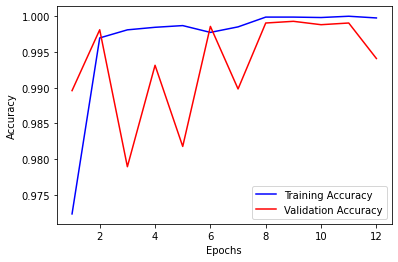

In [ ]:
pred_machine = fit_and_predict_machine(model, source = False)


In [ ]:
df_result1 = build_result_df(pred_machine, source = False, model = 'model1')

df_result1.head()

,anomaly_score,true_machine,pred_machine,true_soundtype,pred_soundtype_proba,section,domain,true_machine_name,pred_machine_name,model
8,-5.314028,0,0,0,0.004898,1,target,ToyCar,ToyCar,model1
10,-6.277788,0,0,1,0.001874,2,source,ToyCar,ToyCar,model1
14,-8.828283,0,0,1,0.000147,0,target,ToyCar,ToyCar,model1
16,-6.187406,0,0,0,0.002051,2,source,ToyCar,ToyCar,model1
20,-6.769014,0,0,1,0.001148,0,source,ToyCar,ToyCar,model1


Store results

In [ ]:
df_results_allmodels = df_result1.copy()

In [ ]:
df_result[df_result['true_machine']!=df_result['pred_machine']]['domain'].value_counts()

target    105
source     38
Name: domain, dtype: int64

In [ ]:
df_result1['true_machine_name'].value_counts()

ToyCar      600
slider      600
ToyTrain    600
fan         600
bearing     600
gearbox     600
valve       600
Name: true_machine_name, dtype: int64

In [ ]:
show_evaluations_machine(df_result1)

***** EVALUATION OF MACHINE CLASSIFICATION ***** 
None
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       600
           2       0.99      0.99      0.99       600
           3       0.95      0.88      0.92       600
           4       0.89      0.99      0.93       600
           5       0.97      0.90      0.93       600
           6       0.98      1.00      0.99       600

    accuracy                           0.97      4200
   macro avg       0.97      0.97      0.97      4200
weighted avg       0.97      0.97      0.97      4200



Pred,0,1,2,3,4,5,6
True,,,,,,,
0,600,0,0,0,0,0,0
1,0,600,0,0,0,0,0
2,0,0,596,0,0,1,3
3,2,0,7,529,46,16,0
4,0,0,0,5,593,1,1
5,0,0,0,22,30,541,7
6,0,0,1,0,1,0,598


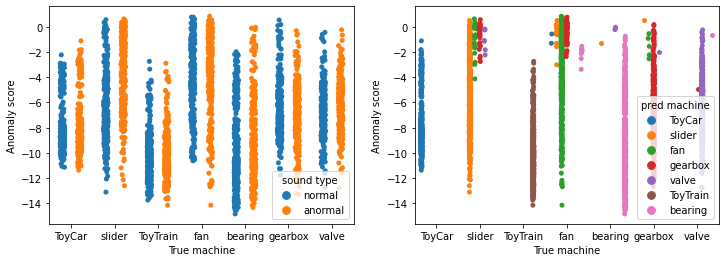

In [ ]:
plot_anomaly_scores(df_result1)

We don't see a clear anomaly score threshold above which there would be only/mainly anormal sounds.

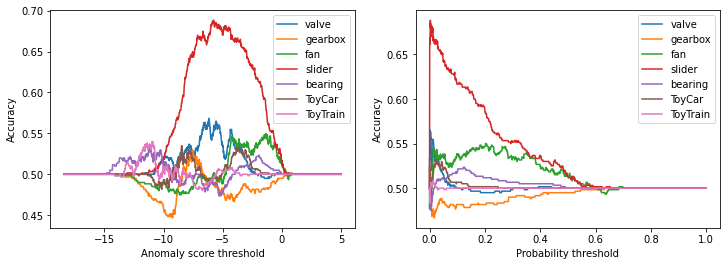

In [ ]:
plot_anomaly_acc_vs_threshold(df_result1)

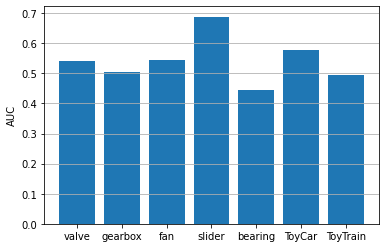

In [ ]:
compute_AUCs(df_result1)

### Repeat for another model

In [ ]:
# Quentin's model with 3 output classes
model = Sequential(
        [Input(shape = (128, 313, 1), name = "Input"),
        Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Dropout(rate=0.1),
        Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'),
        Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Dropout(rate=0.1),
        Conv2D(filters=128, kernel_size=5, padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'),
        Dropout(rate=0.2),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(7, activation='softmax')]
        )

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 313, 32)      320       
                                                                 
 batch_normalization_11 (Bat  (None, 128, 313, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 156, 32)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 64, 156, 32)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 156, 64)       51264     
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 156, 32)      

Epoch 1/100
525/525 [==============================] - 46s 86ms/step - loss: 0.6799 - accuracy: 0.8476 - val_loss: 6.5404 - val_accuracy: 0.4152 - lr: 0.0010
Epoch 2/100
525/525 [==============================] - 38s 72ms/step - loss: 0.1170 - accuracy: 0.9647 - val_loss: 0.0977 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 3/100
525/525 [==============================] - 38s 72ms/step - loss: 0.2262 - accuracy: 0.9589 - val_loss: 468.6977 - val_accuracy: 0.1451 - lr: 0.0010
Epoch 4/100
525/525 [==============================] - 38s 72ms/step - loss: 0.0543 - accuracy: 0.9832 - val_loss: 1.2120 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 5/100
525/525 [==============================] - 39s 74ms/step - loss: 0.0510 - accuracy: 0.9857 - val_loss: 0.0332 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 6/100
525/525 [==============================] - 38s 72ms/step - loss: 0.0434 - accuracy: 0.9891 - val_loss: 0.3494 - val_accuracy: 0.9214 - lr: 0.0010
Epoch 7/100
525/525 [=============================

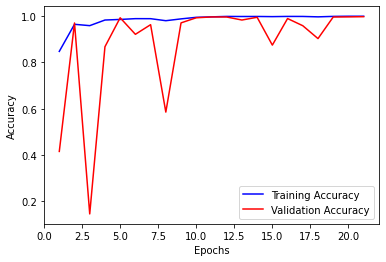

In [ ]:
pred_machine = fit_and_predict_machine(model, source = False)


In [ ]:
df_result2 = build_result_df(pred_machine, model = 'model2', source = False)

df_result2.head()

,anomaly_score,true_machine,pred_machine,true_soundtype,pred_soundtype_proba,section,domain,true_machine_name,pred_machine_name,model
8,-18.420681,0,0,0,0.0,1,target,ToyCar,ToyCar,model2
10,-18.420681,0,0,1,0.0,2,source,ToyCar,ToyCar,model2
14,-18.420681,0,0,1,0.0,0,target,ToyCar,ToyCar,model2
16,-18.420681,0,0,0,0.0,2,source,ToyCar,ToyCar,model2
20,-18.420681,0,0,1,0.0,0,source,ToyCar,ToyCar,model2


In [ ]:
df_results_allmodels = pd.concat([df_results_allmodels, df_result2], axis = 0)

In [ ]:
df_results_allmodels['model'].value_counts()

model1    4200
model2    4200
Name: model, dtype: int64

In [ ]:
df_result2[df_result2['true_machine']!=df_result2['pred_machine']]['domain'].value_counts()

target    135
source     48
Name: domain, dtype: int64

In [ ]:
show_evaluations_machine(df_result2)

***** EVALUATION OF MACHINE CLASSIFICATION ***** 
None
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       600
           1       1.00      1.00      1.00       600
           2       0.99      1.00      1.00       600
           3       0.89      0.94      0.91       600
           4       0.91      0.99      0.94       600
           5       0.98      0.81      0.89       600
           6       0.95      1.00      0.97       600

    accuracy                           0.96      4200
   macro avg       0.96      0.96      0.96      4200
weighted avg       0.96      0.96      0.96      4200



Pred,0,1,2,3,4,5,6
True,,,,,,,
0,580,0,0,9,9,2,0
1,0,600,0,0,0,0,0
2,0,0,599,0,0,0,1
3,0,0,4,561,21,7,7
4,0,0,0,5,592,0,3
5,0,0,0,58,32,487,23
6,0,0,1,0,0,1,598


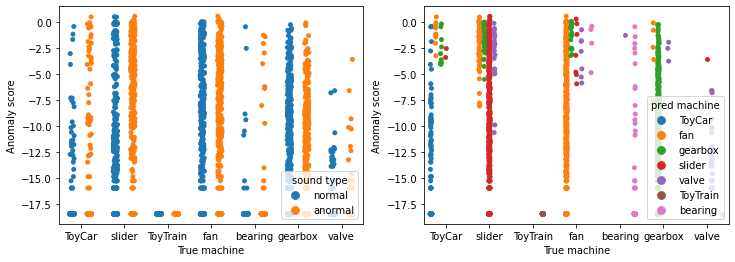

In [ ]:
plot_anomaly_scores(df_result2)

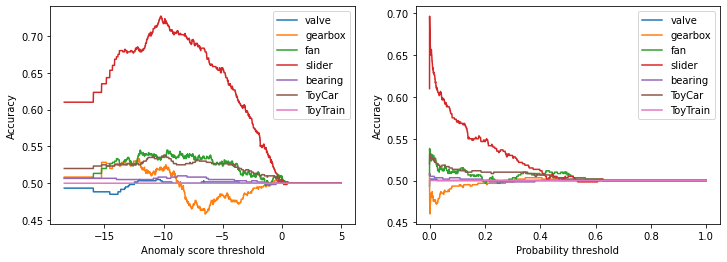

In [ ]:
plot_anomaly_acc_vs_threshold(df_result2)

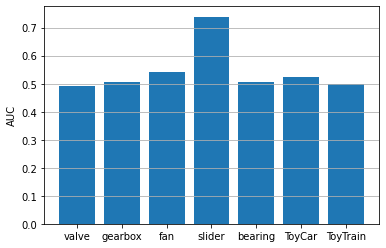

In [ ]:
compute_AUCs(df_result2)


## Try again with another model

In [ ]:
model = Sequential([
        Input(shape = (128, 313, 1), name = "Input"),
        BatchNormalization(),
        Conv2D(filters = 32, kernel_size = (7, 7), padding = 'valid', activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(),
        Conv2D(filters = 64, kernel_size = (3, 3), padding = 'valid', activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(7, activation='softmax')
        ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_14 (Bat  (None, 128, 313, 1)      4         
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 122, 307, 32)      1600      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 61, 153, 32)      0         
 2D)                                                             
                                                                 
 batch_normalization_15 (Bat  (None, 61, 153, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 59, 151, 64)       18496     
                                                      

Epoch 1/100
525/525 [==============================] - 34s 64ms/step - loss: 0.0916 - accuracy: 0.9722 - val_loss: 0.0257 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 2/100
525/525 [==============================] - 29s 55ms/step - loss: 0.0185 - accuracy: 0.9947 - val_loss: 0.0081 - val_accuracy: 0.9976 - lr: 0.0010
Epoch 3/100
525/525 [==============================] - 30s 58ms/step - loss: 0.0053 - accuracy: 0.9987 - val_loss: 0.0023 - val_accuracy: 0.9995 - lr: 0.0010
Epoch 4/100
525/525 [==============================] - 27s 51ms/step - loss: 0.0144 - accuracy: 0.9953 - val_loss: 0.0068 - val_accuracy: 0.9979 - lr: 0.0010
Epoch 5/100
525/525 [==============================] - 24s 46ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0076 - val_accuracy: 0.9974 - lr: 0.0010
Epoch 6/100
525/525 [==============================] - 24s 46ms/step - loss: 0.0049 - accuracy: 0.9984 - val_loss: 0.0084 - val_accuracy: 0.9988 - lr: 0.0010
Epoch 7/100
524/525 [============================>.]

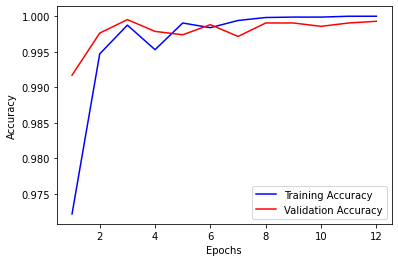

In [ ]:
pred_machine = fit_and_predict_machine(model, source = False)


In [ ]:
df_result3 = build_result_df(pred_machine, model = 'model3', source = False)

df_result3.head()

,anomaly_score,true_machine,pred_machine,true_soundtype,pred_soundtype_proba,section,domain,true_machine_name,pred_machine_name,model
8,-7.307628,0,0,0,0.000670,1,target,ToyCar,ToyCar,model3
10,-9.234203,0,0,1,0.000098,2,source,ToyCar,ToyCar,model3
14,-9.558808,0,0,1,0.000071,0,target,ToyCar,ToyCar,model3
16,-8.772880,0,0,0,0.000155,2,source,ToyCar,ToyCar,model3
20,-8.822602,0,0,1,0.000147,0,source,ToyCar,ToyCar,model3


In [ ]:
df_results_allmodels = pd.concat([df_results_allmodels, df_result3], axis = 0)

In [ ]:
df_results_allmodels['model'].value_counts()

model1    4200
model2    4200
model3    4200
Name: model, dtype: int64

In [ ]:
df_result3[df_result3['true_machine']!=df_result3['pred_machine']]['domain'].value_counts()

target    93
source    44
Name: domain, dtype: int64

In [ ]:
show_evaluations_machine(df_result3)

***** EVALUATION OF MACHINE CLASSIFICATION ***** 
None
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       600
           2       1.00      1.00      1.00       600
           3       0.91      0.94      0.92       600
           4       0.91      0.99      0.94       600
           5       0.98      0.85      0.91       600
           6       0.99      1.00      0.99       600

    accuracy                           0.97      4200
   macro avg       0.97      0.97      0.97      4200
weighted avg       0.97      0.97      0.97      4200



Pred,0,1,2,3,4,5,6
True,,,,,,,
0,600,0,0,0,0,0,0
1,0,600,0,0,0,0,0
2,0,0,599,0,0,0,1
3,0,0,0,564,26,8,2
4,0,0,0,4,592,3,1
5,0,0,0,52,35,510,3
6,0,0,0,0,0,2,598


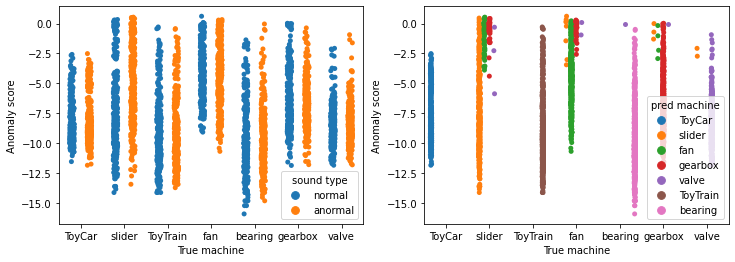

In [ ]:
plot_anomaly_scores(df_result3)

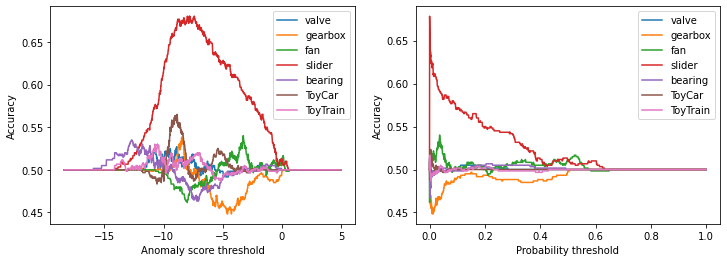

In [ ]:
plot_anomaly_acc_vs_threshold(df_result3)

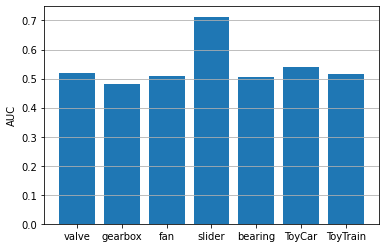

In [ ]:
compute_AUCs(df_result3)

## Try with the original simplest model which worked well

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
model = Sequential([
        Input(shape = (128, 313, 1), name = "Input"),
        BatchNormalization(),
        Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu'),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(7, activation='softmax')
        ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_18 (Bat  (None, 128, 313, 1)      4         
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 124, 309, 32)      832       
                                                                 
 batch_normalization_19 (Bat  (None, 124, 309, 32)     128       
 chNormalization)                                                
                                                                 
 flatten_5 (Flatten)         (None, 1226112)           0         
                                                                 
 dense_13 (Dense)            (None, 128)               156942464 
                                                                 
 batch_normalization_20 (Bat  (None, 128)             

Epoch 1/100
525/525 [==============================] - 42s 78ms/step - loss: 0.1342 - accuracy: 0.9586 - val_loss: 0.0350 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 2/100
525/525 [==============================] - 39s 74ms/step - loss: 0.0112 - accuracy: 0.9974 - val_loss: 0.0306 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 3/100
525/525 [==============================] - 35s 67ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.0187 - val_accuracy: 0.9943 - lr: 0.0010
Epoch 4/100
525/525 [==============================] - 32s 61ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.0060 - val_accuracy: 0.9979 - lr: 0.0010
Epoch 5/100
525/525 [==============================] - 32s 61ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.0059 - val_accuracy: 0.9983 - lr: 0.0010
Epoch 6/100
525/525 [==============================] - 32s 61ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0065 - val_accuracy: 0.9983 - lr: 0.0010
Epoch 7/100
525/525 [==============================]

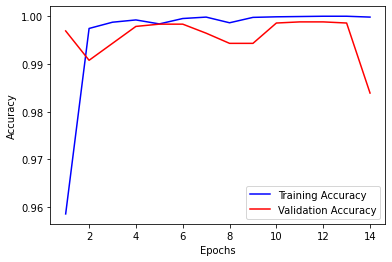

In [ ]:
pred_machine = fit_and_predict_machine(model, source = False)


In [ ]:
df_result4 = build_result_df(pred_machine, model = 'model4', source = False)

df_result4.head()

,anomaly_score,true_machine,pred_machine,true_soundtype,pred_soundtype_proba,section,domain,true_machine_name,pred_machine_name,model
8,-6.469132,0,0,0,0.001548,1,target,ToyCar,ToyCar,model4
10,-8.762159,0,0,1,0.000157,2,source,ToyCar,ToyCar,model4
14,-7.462943,0,0,1,0.000574,0,target,ToyCar,ToyCar,model4
16,-9.577565,0,0,0,0.000069,2,source,ToyCar,ToyCar,model4
20,-8.568507,0,0,1,0.000190,0,source,ToyCar,ToyCar,model4


In [ ]:
df_results_allmodels = pd.concat([df_results_allmodels, df_result4], axis = 0)

In [ ]:
df_result4[df_result4['true_machine']!=df_result4['pred_machine']]['domain'].value_counts()

target    82
source    34
Name: domain, dtype: int64

In [ ]:
show_evaluations_machine(df_result4)

***** EVALUATION OF MACHINE CLASSIFICATION ***** 
None
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       600
           2       1.00      1.00      1.00       600
           3       0.91      0.96      0.94       600
           4       0.92      0.98      0.95       600
           5       0.99      0.86      0.92       600
           6       1.00      1.00      1.00       600

    accuracy                           0.97      4200
   macro avg       0.97      0.97      0.97      4200
weighted avg       0.97      0.97      0.97      4200



Pred,0,1,2,3,4,5,6
True,,,,,,,
0,600,0,0,0,0,0,0
1,0,600,0,0,0,0,0
2,0,0,600,0,0,0,0
3,0,0,0,577,19,4,0
4,0,0,0,8,590,2,0
5,0,0,0,46,33,518,3
6,1,0,0,0,0,0,599


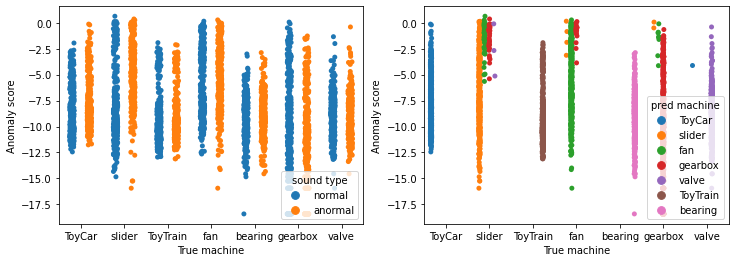

In [ ]:
plot_anomaly_scores(df_result4)

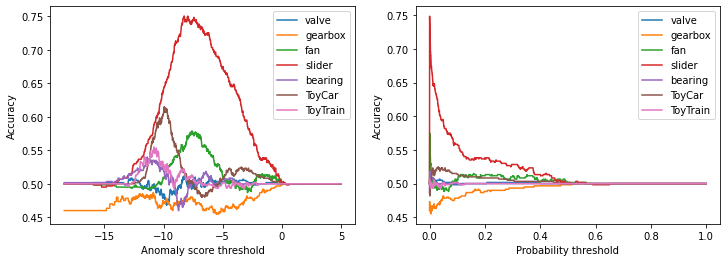

In [ ]:
plot_anomaly_acc_vs_threshold(df_result4)

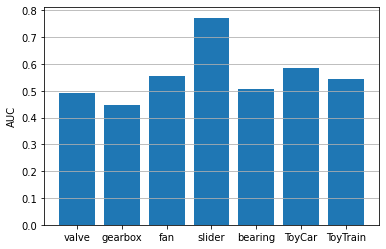

In [ ]:
compute_AUCs(df_result4)

#### Take the best model per machine

In [ ]:
df_results_allmodels.to_pickle('results_allmodels_predmachine.csv')
#df_results_allmodels = pd.read_pickle('results_allmodels_predmachine.csv')

In [ ]:
df_results_allmodels['model'].value_counts()

model1    4200
model2    4200
model3    4200
model4    4200
Name: model, dtype: int64

In [ ]:
df_best_auc_DCASE = {'valve': 0.9384, 'gearbox': 0.8928, 'fan': 0.7011, 'slider': 0.9008, \
                     'bearing': 0.8196, 'ToyCar': 0.8150, 'ToyTrain': 0.7622}

def compute_best_AUC(df_res, df_comp):
    dict_aucs = {}
    dict_models = {}
    for machine in ['valve', 'gearbox', 'fan', 'slider', 'bearing', 'ToyCar', 'ToyTrain']:
        auc_max = 0
        best_model = ''
        for model in ['model1', 'model2', 'model3', 'model4']:
            df_res_mach_model = df_res[(df_res['true_machine_name'] == machine) & (df_res['model'] == model)].copy()
            auc = roc_auc_score(df_res_mach_model['true_soundtype'], df_res_mach_model['pred_soundtype_proba'])
            if auc > auc_max:
                auc_max = auc
                best_model = model
        dict_aucs[machine] = auc_max
        dict_models[machine] = best_model

    cmap = {'model1': 'deepskyblue', 'model2': 'darkblue', 'model3':'r', 'model4':'g'}

    assert list(dict_aucs.keys())==list(df_comp.keys())   # Check that the machines are ordered identically in the 2 dfs

    fig = plt.figure(figsize = (6, 4))
    plt.xticks([i + 0.2 for i in range(7)], dict_aucs.keys())
    plt.yticks([0.1*i for i in range(10)])
    plt.ylabel("AUC")
    plt.grid(True, axis = 'y')
    plt.bar(range(7), dict_aucs.values(), color = [cmap[i] for i in dict_models.values()], width = 0.4)
    x = [i + 0.4 for i in range(7)]
    plt.bar(x, df_comp.values(), color ='crimson', width = 0.4)
    plt.title("Best AUC (left) among 4 DL models (bar color)\n\
    compared to the best AUCs of the challenge (right)")

compute_best_AUC(df_results_allmodels, df_best_auc_DCASE)

NameError: ignored

## Repeat with the best model by considering only data from the source domain

Clearly we should consider the best model per machine (ensemble method) but I'm too lazy to do that. I choose the apparent best average model.

In [ ]:
model = Sequential([
        Input(shape = (128, 313, 1), name = "Input"),
        BatchNormalization(),
        Conv2D(filters = 32, kernel_size = (7, 7), padding = 'valid', activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(),
        Conv2D(filters = 64, kernel_size = (3, 3), padding = 'valid', activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(7, activation='softmax')
        ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_14 (Bat  (None, 128, 313, 1)      4         
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 122, 307, 32)      1600      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 61, 153, 32)      0         
 2D)                                                             
                                                                 
 batch_normalization_15 (Bat  (None, 61, 153, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 59, 151, 64)       18496     
                                                      

Epoch 1/100
520/520 [==============================] - 37s 66ms/step - loss: 0.1061 - accuracy: 0.9656 - val_loss: 0.0381 - val_accuracy: 0.9894 - lr: 0.0010
Epoch 2/100
520/520 [==============================] - 23s 44ms/step - loss: 0.0141 - accuracy: 0.9963 - val_loss: 0.0178 - val_accuracy: 0.9947 - lr: 0.0010
Epoch 3/100
520/520 [==============================] - 23s 44ms/step - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.0153 - val_accuracy: 0.9957 - lr: 0.0010
Epoch 4/100
520/520 [==============================] - 23s 44ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.0066 - val_accuracy: 0.9983 - lr: 0.0010
Epoch 5/100
520/520 [==============================] - 23s 45ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0028 - val_accuracy: 0.9995 - lr: 0.0010
Epoch 6/100
520/520 [==============================] - 23s 44ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0046 - val_accuracy: 0.9988 - lr: 0.0010
Epoch 7/100
520/520 [==============================]

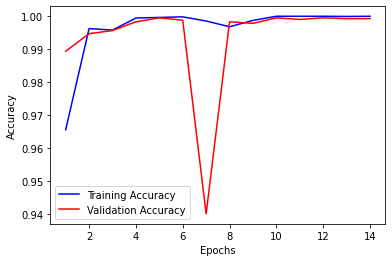

In [ ]:
pred_machine = fit_and_predict_machine(model, source = True)


In [ ]:
df_result = build_result_df(pred_machine, source = True)

df_result.head()

,anomaly_score,true_machine,pred_machine,true_soundtype,pred_soundtype_proba,section,domain,true_machine_name
0,-11.476467,4,4,0,1.037121e-05,1,source,gearbox
3,-14.843773,4,4,1,3.576279e-07,2,source,gearbox
7,-14.843773,4,4,1,3.576279e-07,2,source,gearbox
16,-6.626857,4,4,1,1.322567e-03,0,source,gearbox
20,-9.276608,4,4,1,9.357929e-05,1,source,gearbox


In [ ]:
df_result[df_result['true_machine']!=df_result['pred_machine']]['domain'].value_counts()

source    35
Name: domain, dtype: int64

In [ ]:
show_evaluations_machine(df_result)

***** EVALUATION OF MACHINE CLASSIFICATION ***** 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       0.94      0.97      0.95       300
           4       0.99      0.99      0.99       300
           5       0.99      0.93      0.96       300
           6       0.99      1.00      1.00       300

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100



Pred,0,1,2,3,4,5,6
True,,,,,,,
0,300,0,0,0,0,0,0
1,0,300,0,0,0,0,0
2,0,0,300,0,0,0,0
3,8,0,0,290,0,1,1
4,0,0,0,2,297,1,0
5,0,0,0,18,3,278,1
6,0,0,0,0,0,0,300


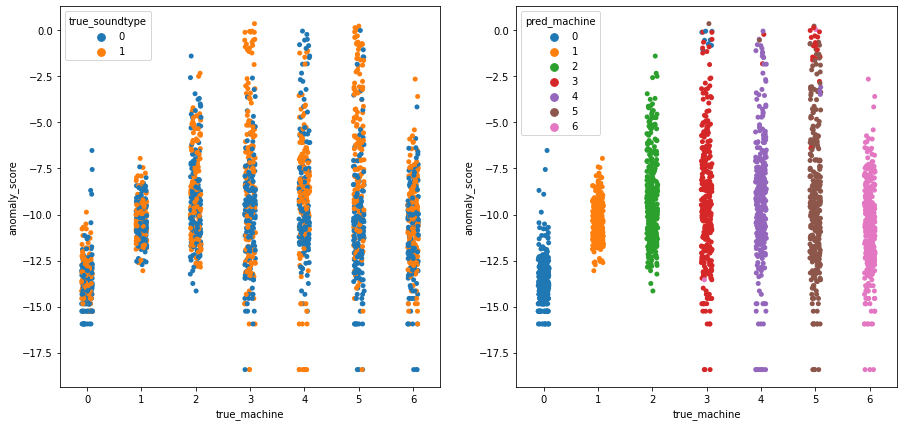

In [ ]:
plot_anomaly_scores(df_result)

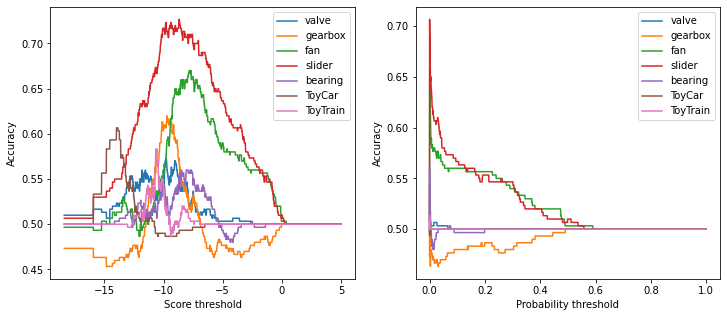

In [ ]:
plot_anomaly_acc_vs_threshold(df_result)

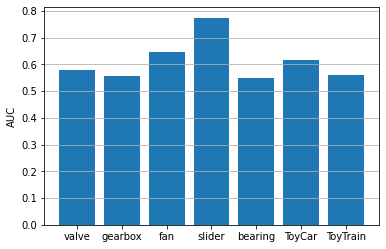

In [ ]:
compute_AUCs(df_result)

Slightly better but still bad

## Other try : only data from the source domain and train section per section

In [ ]:
model = Sequential([
        Input(shape = (128, 313, 1), name = "Input"),
        BatchNormalization(),
        Conv2D(filters = 32, kernel_size = (7, 7), padding = 'valid', activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(),
        Conv2D(filters = 64, kernel_size = (3, 3), padding = 'valid', activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(7, activation='softmax')
        ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_14 (Bat  (None, 128, 313, 1)      4         
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 122, 307, 32)      1600      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 61, 153, 32)      0         
 2D)                                                             
                                                                 
 batch_normalization_15 (Bat  (None, 61, 153, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 59, 151, 64)       18496     
                                                      

#### Start with section 0

Epoch 1/100
174/174 [==============================] - 10s 59ms/step - loss: 5.8373e-04 - accuracy: 1.0000 - val_loss: 9.3558e-05 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 2/100
174/174 [==============================] - 8s 48ms/step - loss: 5.6788e-04 - accuracy: 1.0000 - val_loss: 1.4007e-04 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 3/100
174/174 [==============================] - 8s 45ms/step - loss: 7.2794e-04 - accuracy: 0.9996 - val_loss: 5.6707e-04 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 4/100
174/174 [==============================] - 8s 44ms/step - loss: 7.4809e-04 - accuracy: 0.9996 - val_loss: 4.7233e-04 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 5/100
174/174 [==============================] - 8s 45ms/step - loss: 2.5783e-04 - accuracy: 1.0000 - val_loss: 2.2661e-04 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 6/100
173/174 [============================>.] - ETA: 0s - loss: 7.8406e-05 - accuracy: 1.0000
Epoch 6: ReduceLROnPlateau reducing learning rate to 

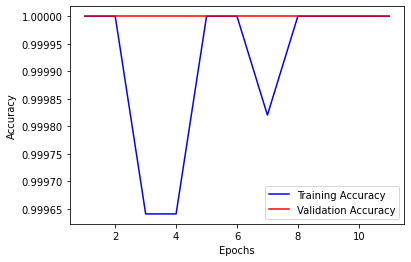

In [ ]:
pred_machine = fit_and_predict_machine(model, source = True, section = True, section_num = 0)


In [ ]:
df_result = build_result_df(pred_machine, source = True, section = True, section_num = 0)

df_result.head()

,anomaly_score,true_machine,pred_machine,true_soundtype,pred_soundtype_proba,section,domain,true_machine_name
16,-8.574172,4,4,1,1.888871e-04,0,source,gearbox
26,-12.228808,4,4,0,4.887581e-06,0,source,gearbox
39,-8.216564,4,4,0,2.700686e-04,0,source,gearbox
43,-14.332947,4,4,0,5.960464e-07,0,source,gearbox
144,-9.074296,4,4,1,1.145601e-04,0,source,gearbox


In [ ]:
show_evaluations_machine(df_result, source = True, section = True, section_num = 0)

***** EVALUATION OF MACHINE CLASSIFICATION ***** 
source domain - section 0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      0.99      0.99       100
           4       0.99      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00       100

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



Pred,0,1,2,3,4,5,6
True,,,,,,,
0,100,0,0,0,0,0,0
1,0,100,0,0,0,0,0
2,0,0,100,0,0,0,0
3,0,0,0,99,1,0,0
4,0,0,0,0,100,0,0
5,0,0,0,0,0,100,0
6,0,0,0,0,0,0,100


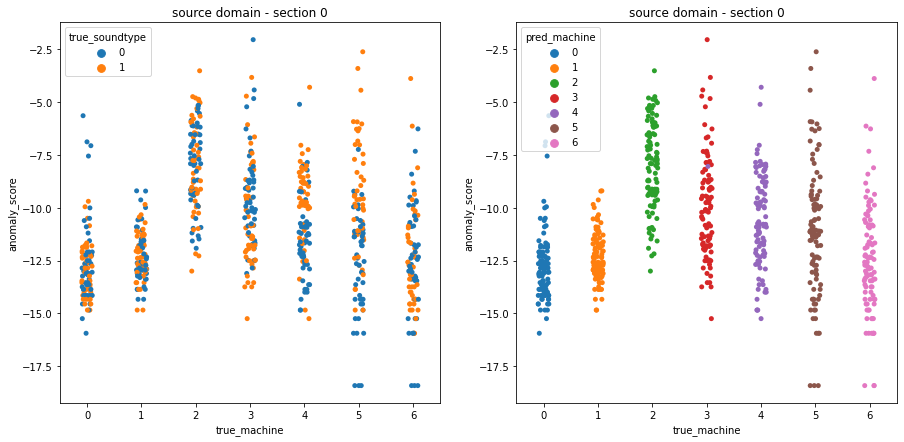

In [ ]:
plot_anomaly_scores(df_result, source = True, section = True, section_num = 0)

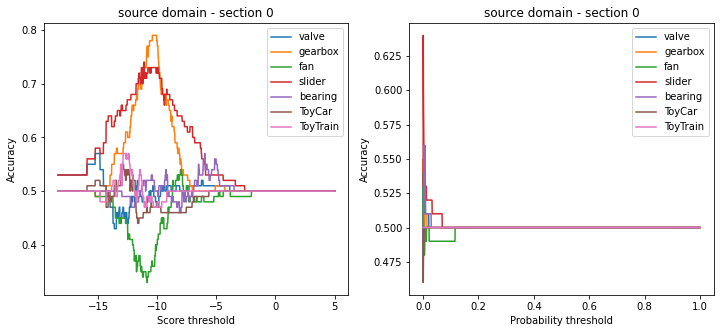

In [ ]:
plot_anomaly_acc_vs_threshold(df_result, source = True, section = True, section_num = 0)

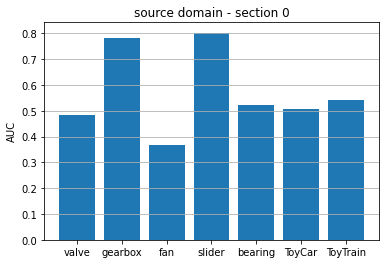

In [ ]:
compute_AUCs(df_result, source = True, section = True, section_num = 0)

#### Now section 1

Epoch 1/100
174/174 [==============================] - 12s 70ms/step - loss: 0.0060 - accuracy: 0.9986 - val_loss: 2.0510e-04 - val_accuracy: 1.0000 - lr: 9.0000e-05
Epoch 2/100
174/174 [==============================] - 9s 54ms/step - loss: 6.4247e-04 - accuracy: 1.0000 - val_loss: 9.4430e-05 - val_accuracy: 1.0000 - lr: 9.0000e-05
Epoch 3/100
174/174 [==============================] - 8s 45ms/step - loss: 5.1789e-04 - accuracy: 1.0000 - val_loss: 8.6651e-05 - val_accuracy: 1.0000 - lr: 9.0000e-05
Epoch 4/100
174/174 [==============================] - 8s 45ms/step - loss: 2.1273e-04 - accuracy: 1.0000 - val_loss: 1.2205e-04 - val_accuracy: 1.0000 - lr: 9.0000e-05
Epoch 5/100
174/174 [==============================] - 8s 45ms/step - loss: 1.9722e-04 - accuracy: 1.0000 - val_loss: 1.4842e-04 - val_accuracy: 1.0000 - lr: 9.0000e-05
Epoch 6/100
174/174 [==============================] - ETA: 0s - loss: 1.2005e-04 - accuracy: 1.0000
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.70

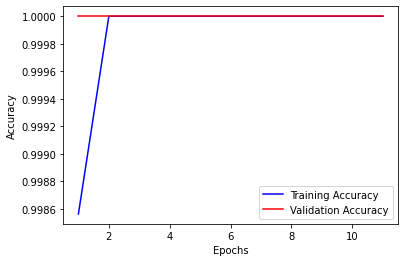

In [ ]:
pred_machine = fit_and_predict_machine(model, source = True, section = True, section_num = 1)


In [ ]:
df_result = build_result_df(pred_machine, source = True, section = True, section_num = 1)

df_result.head()

,anomaly_score,true_machine,pred_machine,true_soundtype,pred_soundtype_proba,section,domain,true_machine_name
16,-8.574172,4,4,1,1.888871e-04,0,source,gearbox
26,-12.228808,4,4,0,4.887581e-06,0,source,gearbox
39,-8.216564,4,4,0,2.700686e-04,0,source,gearbox
43,-14.332947,4,4,0,5.960464e-07,0,source,gearbox
144,-9.074296,4,4,1,1.145601e-04,0,source,gearbox


In [ ]:
show_evaluations_machine(df_result, source = True, section = True, section_num = 1)

***** EVALUATION OF MACHINE CLASSIFICATION ***** 
source domain - section 0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      0.99      0.99       100
           4       0.99      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00       100

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



Pred,0,1,2,3,4,5,6
True,,,,,,,
0,100,0,0,0,0,0,0
1,0,100,0,0,0,0,0
2,0,0,100,0,0,0,0
3,0,0,0,99,1,0,0
4,0,0,0,0,100,0,0
5,0,0,0,0,0,100,0
6,0,0,0,0,0,0,100


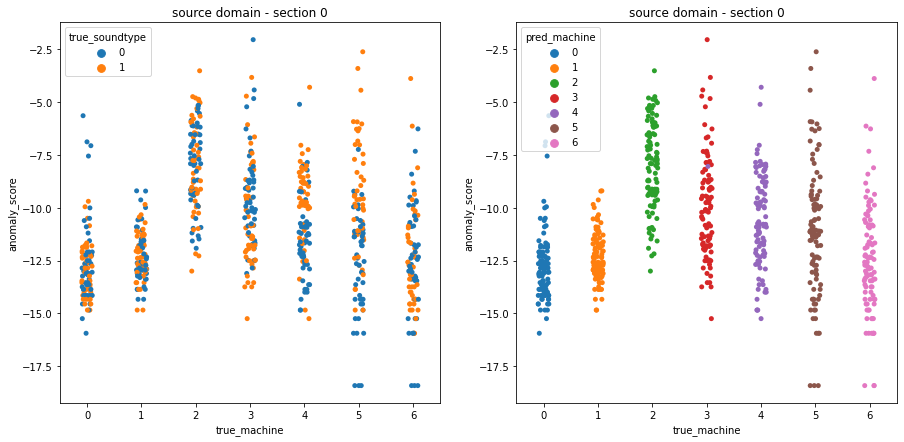

In [ ]:
plot_anomaly_scores(df_result, source = True, section = True, section_num = 1)

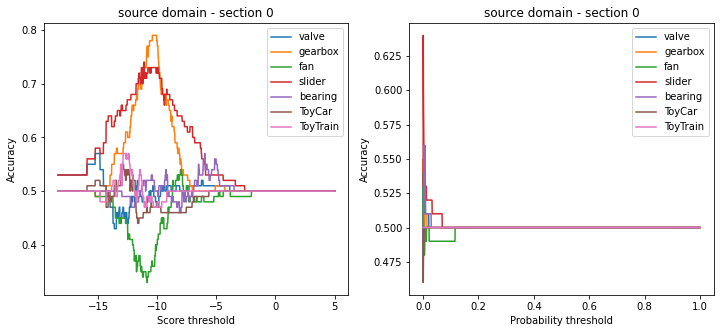

In [ ]:
plot_anomaly_acc_vs_threshold(df_result, source = True, section = True, section_num = 1)

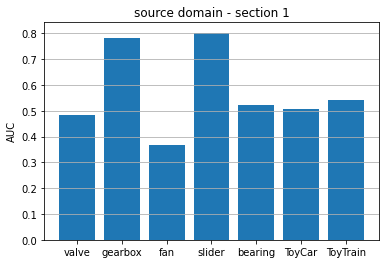

In [ ]:
compute_AUCs(df_result, source = True, section = True, section_num = 1)

#### Finish with section 2

Epoch 1/100
174/174 [==============================] - 9s 52ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 3.2429e-04 - val_accuracy: 1.0000 - lr: 2.7000e-05
Epoch 2/100
174/174 [==============================] - 10s 59ms/step - loss: 3.4222e-04 - accuracy: 1.0000 - val_loss: 9.2821e-05 - val_accuracy: 1.0000 - lr: 2.7000e-05
Epoch 3/100
174/174 [==============================] - 8s 48ms/step - loss: 2.2672e-04 - accuracy: 1.0000 - val_loss: 7.7322e-05 - val_accuracy: 1.0000 - lr: 2.7000e-05
Epoch 4/100
174/174 [==============================] - 8s 44ms/step - loss: 1.7421e-04 - accuracy: 1.0000 - val_loss: 6.4613e-05 - val_accuracy: 1.0000 - lr: 2.7000e-05
Epoch 5/100
174/174 [==============================] - 8s 44ms/step - loss: 1.2420e-04 - accuracy: 1.0000 - val_loss: 5.7505e-05 - val_accuracy: 1.0000 - lr: 2.7000e-05
Epoch 6/100
174/174 [==============================] - ETA: 0s - loss: 1.8880e-04 - accuracy: 1.0000
Epoch 6: ReduceLROnPlateau reducing learning rate to 8.10

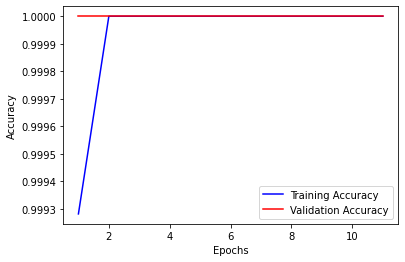

In [ ]:
pred_machine = fit_and_predict_machine(model, source = True, section = True, section_num = 2)


In [ ]:
df_result = build_result_df(pred_machine, source = True, section = True, section_num = 2)

df_result.head()

,anomaly_score,true_machine,pred_machine,true_soundtype,pred_soundtype_proba,section,domain,true_machine_name
3,-13.996474,4,4,1,8.344650e-07,2,source,gearbox
7,-14.556090,4,4,1,4.768372e-07,2,source,gearbox
70,-9.107090,4,4,1,1.108646e-04,2,source,gearbox
83,-6.925862,4,4,0,9.810925e-04,2,source,gearbox
155,-11.022388,4,4,0,1.633167e-05,2,source,gearbox


In [ ]:
show_evaluations_machine(df_result, source = True, section = True, section_num = 2)

***** EVALUATION OF MACHINE CLASSIFICATION ***** 
source domain - section 2
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       0.98      0.83      0.90       100
           4       0.87      0.99      0.93       100
           5       1.00      0.93      0.96       100
           6       1.00      1.00      1.00       100

    accuracy                           0.96       700
   macro avg       0.97      0.96      0.96       700
weighted avg       0.97      0.96      0.96       700



Pred,0,1,2,3,4,5,6
True,,,,,,,
0,100,0,0,0,0,0,0
1,0,100,0,0,0,0,0
2,0,0,100,0,0,0,0
3,8,0,0,83,9,0,0
4,0,0,0,1,99,0,0
5,0,0,0,1,6,93,0
6,0,0,0,0,0,0,100


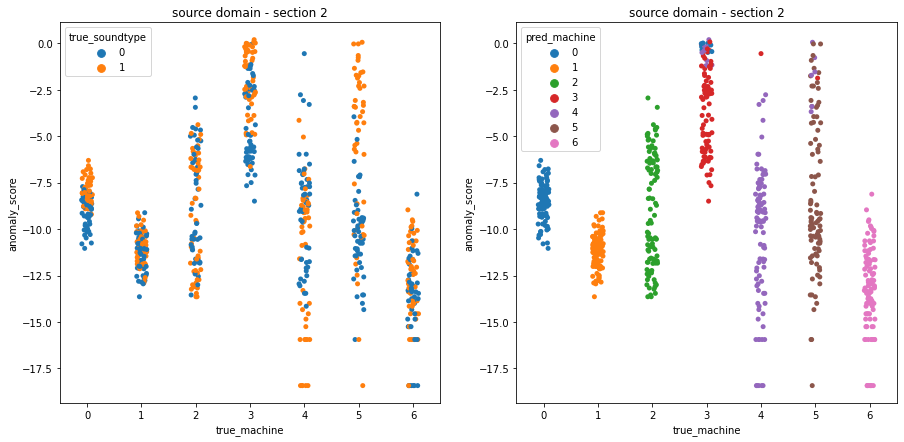

In [ ]:
plot_anomaly_scores(df_result, source = True, section = True, section_num = 2)

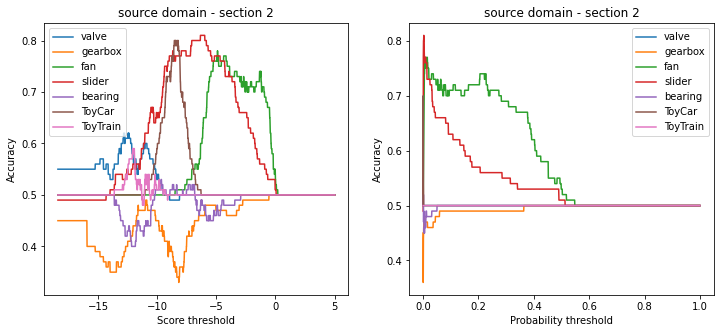

In [ ]:
plot_anomaly_acc_vs_threshold(df_result, source = True, section = True, section_num = 2)

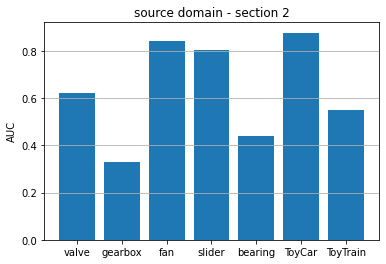

In [ ]:
compute_AUCs(df_result, source = True, section = True, section_num = 2)